<a href="https://colab.research.google.com/github/byarciptap/Fake_News_Classification/blob/main/Fake_News_Classification_Text_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fake News Classification Text with LSTM**

Name : Byar Cipta Pakartilinuwih

Profile Dicoding : https://www.dicoding.com/users/byarcipta/academies


# **About the Project**
This notebook was created to fulfill the project of the course Dicoding: *Belajar Pengembangan Machine Learning*, "Proyek Pertama: Membuat Model NLP dengan TensorFlow". As additional information, this project will use Artificial Neural Networks with Tensor Flow and Sequential models

# **Summary**

in this fake news classification dataset, we use Spacy Large Model along with Keras LSTM with Vectorization input layer and Embedding Layer. After 30 epochs we get an accuracy 99.5% on validation set.

# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import regularizers, optimizers
from keras.layers.experimental.preprocessing import TextVectorization
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, GlobalMaxPool1D
from keras.models import Sequential
from keras.initializers import Constant
import keras.metrics as kmetrics

import tensorflow as tf
!pip install -U spacy
!python -m spacy download en_core_web_lg

import spacy
import en_core_web_lg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.2
    Uninstalling spacy-3.7.2:
      Successfully uninstalled spacy-3.7.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# **Load Dataset**

In [ ]:
fake_df = pd.read_csv("/content/drive/MyDrive/Dicoding/Belajar Pengembangan Machine Learning/fake.csv")
true_df = pd.read_csv("/content/drive/MyDrive/Dicoding/Belajar Pengembangan Machine Learning/true.csv")

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Add fake label into dataset


In [ ]:
# create the two values for fake column to append to each of the two dfs.
true_df['fake'] = 0.0
fake_df['fake'] = 1.0

In [ ]:
# concat true df and fake df
news_df = pd.concat([true_df,fake_df])

In [ ]:
news_df.head(10)

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0.0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0.0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0.0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0.0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0.0
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",0.0
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",0.0
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",0.0
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",0.0
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",0.0


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    44898 non-null  object 
 1   text     44898 non-null  object 
 2   subject  44898 non-null  object 
 3   date     44898 non-null  object 
 4   fake     44898 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.1+ MB


# **EDA**

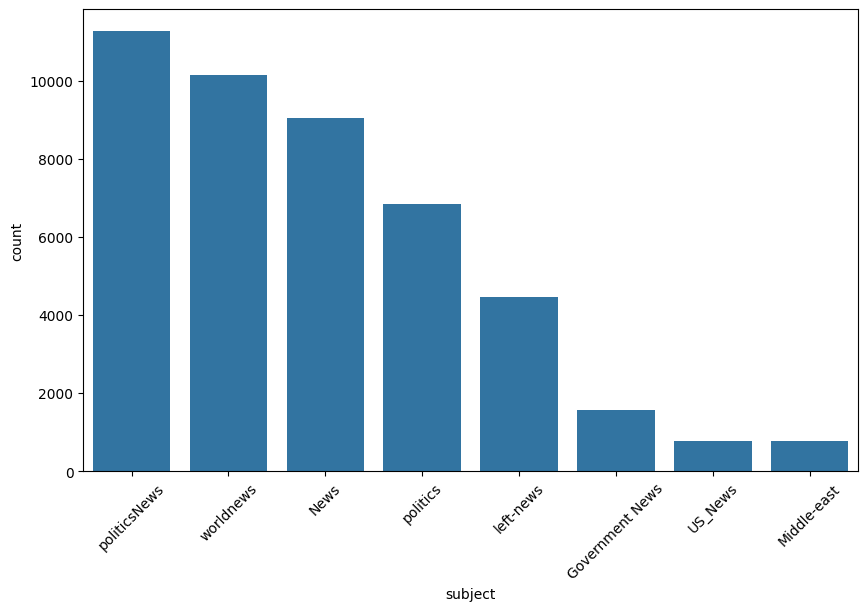

In [ ]:
# plot subject of news_df
plt.figure(figsize=(10, 6))
sorted_subjects = news_df['subject'].value_counts().index
sns.countplot(data=news_df, x='subject', order=sorted_subjects)
plt.xticks(rotation=45)

plt.show()

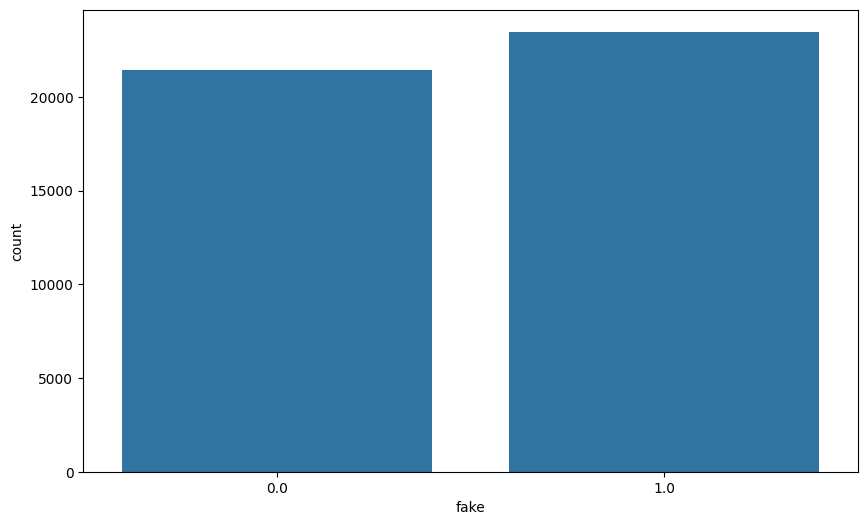

In [ ]:
# plot distribution of fake column
plt.figure(figsize=(10, 6))
sns.countplot(data=news_df, x='fake')
plt.xticks(rotation=0)

plt.show()

# **Pre-processing data**

In [ ]:
shuffled_news_df = news_df.sample(frac=1).reset_index(drop=True)
shuffled_news_df.head()

,title,text,subject,date,fake
0,Clinton Supporter Claims Credit For Multiple ...,"Sure, we get it you trolled them teehee. Troll...",News,"April 26, 2016",1.0
1,Irish opposition leader says PM's party prepar...,DUBLIN (Reuters) - The party of Irish Prime Mi...,worldnews,"November 24, 2017",0.0
2,Ted Cruz Awkwardly Explains Why Texas Should ...,U.S. Sen. Ted Cruz was against federal aid for...,News,"August 29, 2017",1.0
3,Trump Jr.’s Latest Move Proves That Russia In...,Proving that the biggest obstacle to his presi...,News,"July 10, 2017",1.0
4,White Man Murders Cop And Racist Media Stays ...,"Jason Brown, despite the colorful appellatio...",News,"July 29, 2017",1.0


In [ ]:
shuffled_news_df[shuffled_news_df.fake == 0.0]['text'].apply(lambda row: len(row.split())).quantile([0.25,0.5,0.75,0.90,0.95])

0.25    148.0
0.50    359.0
0.75    525.0
0.90    775.0
0.95    894.0
Name: text, dtype: float64

In [ ]:
shuffled_news_df[shuffled_news_df.fake == 1.0]['text'].apply(lambda row: len(row.split())).quantile([0.25,0.5,0.75,0.90,0.95])

0.25    240.0
0.50    363.0
0.75    506.0
0.90    709.0
0.95    926.0
Name: text, dtype: float64

In [ ]:
# create X and y variable for modelling
X = shuffled_news_df['text']
y = shuffled_news_df['fake']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

## Tokenization
We use the tokenizer just to get a sense of the word frequencies. Later, however, we use the vectorizer for the modelling step.

In [ ]:
tokenizer = Tokenizer()
# Applying the tokenizer on all rows of the text feature in the shuffled dataset.
fit_text_train = X_train
tokenizer.fit_on_texts(fit_text_train)


In [ ]:
print("The document count",tokenizer.document_count)

The document count 35918


# **Modelling**

## Text Vectorization and Word Embedding

Notes: For vectorization we make use of the top 10000 most frequent tokens and truncate/pad stories to 300 words.

In [ ]:
nlp = en_core_web_lg.load()
news_vectorizer = TextVectorization(max_tokens=10000,output_sequence_length=300)

In [ ]:
# We fit the vectorizer on our text and extract our corpus.
news_vectorizer.adapt(X_train.to_numpy())
vocab = news_vectorizer.get_vocabulary()

In [ ]:
len(vocab),type(str(vocab[2]))

(10000, str)

## Create Embedding Matrix

Notes : Our embeddings are from spacy and our word index is from the keras vectorizer vocabulary list. We map these two into the embedding matrix.

In [ ]:
# Generating the embedding matrix
ntokens = len(vocab)
embed_dim = len(nlp('The').vector)
embed_matrix = np.zeros((ntokens,embed_dim))
for i, word in tqdm(enumerate(vocab)):
    embed_matrix[i] = nlp(str(word)).vector

10000it [01:34, 105.72it/s]


## Create Embedding Layer

Notes :We use the embedding matrix to create the embedding layer for our LSTM. Note the trainable=False keyword argument. This means the embeddings are already trained and should not be updated.

In [ ]:
# Load the embedding matrix as the weights matrix for the embedding layer
Embed_layer=Embedding(
    ntokens,
    embed_dim,
    embeddings_initializer=Constant(embed_matrix),
    trainable=False)

# **Build and Train the Model**

In [ ]:
# Fitting the model.  We fit a big model as the dataset is huge
model = Sequential()
# The vectorizer layer
model.add(Input(shape=(1,),dtype=tf.string))
model.add(news_vectorizer)
# The embedding layer
model.add(Embed_layer)

model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=1e-5,l2=1e-4)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=1e-5,l2=1e-4)))
model.add(Dense(1))

# Now add in the optimizer
#adam = optimizers.Adam(learning_rate=.01, decay=1e-2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',kmetrics.Precision(),kmetrics.Recall()])

# Print the summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 300)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 300, 300)          3000000   
                                                                 
 lstm (LSTM)                 (None, 300, 25)           32600     
                                                                 
 global_max_pooling1d (Glob  (None, 25)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 32)                8

In [ ]:
y_train.values[:2]

array([1., 1.])

In [ ]:
# Model callback to stop training if accuracy > 0.98
class MyCallbackStopTraining(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.98:
            print("\nThe model accuracy has reached more than 98%, training data is stopped.")
            self.model.stop_training = True

In [ ]:
n_epochs = 30
batch_size = 100
# Fitting the model
history = model.fit(x=X_train,y=y_train,
          batch_size = batch_size,
          epochs = n_epochs,
          validation_split=.3,
          callbacks=[MyCallbackStopTraining()]
                    )

Epoch 1/30
252/252 [==============================] - 143s 567ms/step - loss: 0.7718 - accuracy: 0.6779 - precision: 0.6954 - recall: 0.6882 - val_loss: 0.4334 - val_accuracy: 0.8770 - val_precision: 0.9469 - val_recall: 0.8079
Epoch 2/30
252/252 [==============================] - 121s 480ms/step - loss: 0.7451 - accuracy: 0.6970 - precision: 0.7083 - recall: 0.7196 - val_loss: 0.3994 - val_accuracy: 0.8847 - val_precision: 0.9528 - val_recall: 0.8179
Epoch 3/30
252/252 [==============================] - 139s 553ms/step - loss: 0.6796 - accuracy: 0.7179 - precision: 0.7476 - recall: 0.6988 - val_loss: 0.5668 - val_accuracy: 0.6177 - val_precision: 0.9966 - val_recall: 0.2625
Epoch 4/30
252/252 [==============================] - 120s 474ms/step - loss: 0.8007 - accuracy: 0.6948 - precision: 0.7271 - recall: 0.6706 - val_loss: 0.4107 - val_accuracy: 0.8525 - val_precision: 0.7990 - val_recall: 0.9557
Epoch 5/30
252/252 [==============================] - 139s 551ms/step - loss: 0.7571 - a

# **Training Performance**

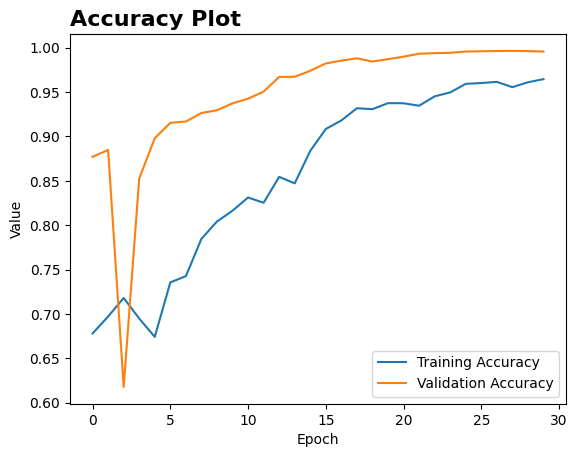

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot', fontweight="bold", loc="left", fontsize="16")
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

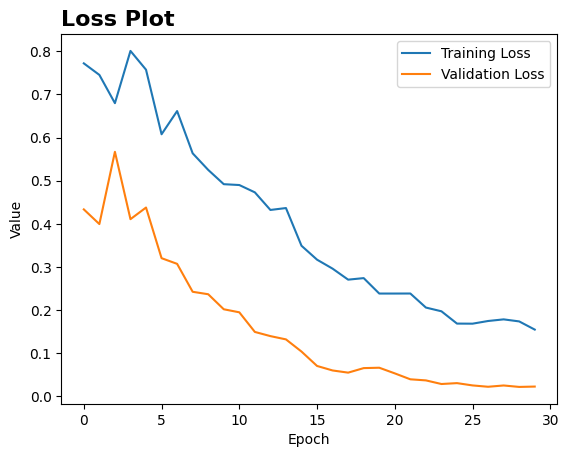

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot', fontweight="bold", loc="left", fontsize="16")
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

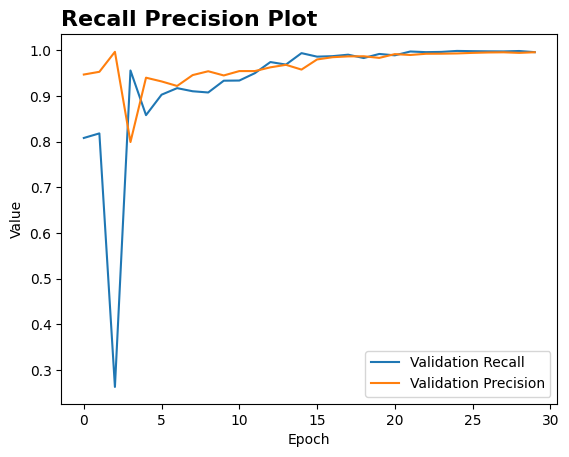

In [ ]:
# Plot recall precision
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Recall Precision Plot', fontweight="bold", loc="left", fontsize="16")
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()